Device: cpu
Using toy corpus (replicated). Size: 29400
Vocab size: 17
Epoch 1/10  Train Loss: 0.3122  Val Loss: 0.0513
Epoch 2/10  Train Loss: 0.0484  Val Loss: 0.0469
Epoch 3/10  Train Loss: 0.0462  Val Loss: 0.0456
Epoch 4/10  Train Loss: 0.0456  Val Loss: 0.0454
Epoch 5/10  Train Loss: 0.0453  Val Loss: 0.0451
Epoch 6/10  Train Loss: 0.0451  Val Loss: 0.0450
Epoch 7/10  Train Loss: 0.0450  Val Loss: 0.0449
Epoch 8/10  Train Loss: 0.0450  Val Loss: 0.0449
Epoch 9/10  Train Loss: 0.0449  Val Loss: 0.0450
Epoch 10/10  Train Loss: 0.0449  Val Loss: 0.0448


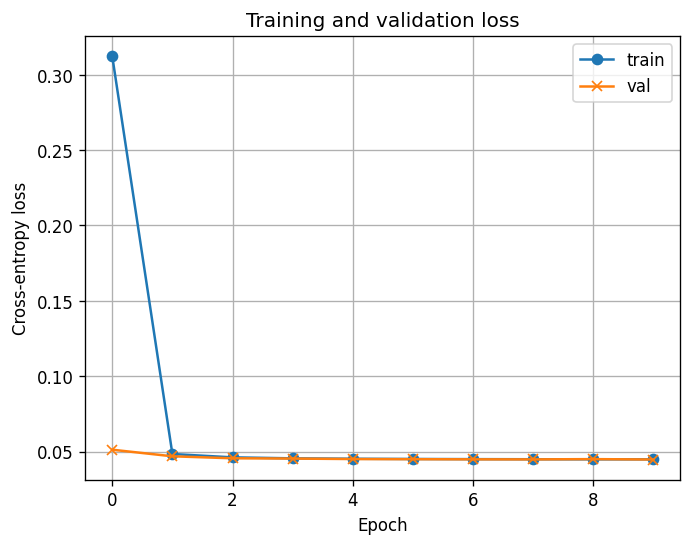


--- Temperature 0.7 sample (first 300 chars) ---

hello

helium

helpful

hero

hey you

how are you

hello world

hello there

help me

hell

hellohello

helium

helpful

hero

hey you

how are you

hello world

hello there

help me

hell

hellohello

helium

helpful

hero

hey you

how are you

hello world

hello there

help me

hell

hellohello



--- Temperature 1.0 sample (first 300 chars) ---

hello world

hello there

help me

hell

hellohello

helium

helpful

hero

hey you

how are you

hello world

hello there

help me

hell

hellohello

helium

helpful

hero

hey you

how are you

hello world

hello there

help me

hell

hellohello

helium

helpful

hero

hey you

how are you

hello w

--- Temperature 1.2 sample (first 300 chars) ---

hello there

help me

hell

hellohello

helium

helpful

hero

hey you

how are you

hello world

hello there

help me

hell

hellohello

helium

helpful

hero

hey you

how are you

hello world

hello there

help me

hell

hellohello

helium


In [3]:
# Q1 — Character-Level RNN Language Model 

# -------------------- Imports & device --------------------
import os, random, math
import numpy as np
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 120
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -------------------- Q1.0 Hyperparameters (edit as needed) --------------------
hidden_size = 128      # 64-256 recommended
num_layers = 1
seq_len = 50           # 50-100 recommended
batch_size = 64
epochs = 10            # 5-20 recommended
lr = 0.001
emb_size = 64
rnn_type = "gru"       # options: "gru", "lstm", "vanilla"
grad_clip = 5.0
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)

# -------------------- Q1.1 Data (toy fallback or data.txt) --------------------
# Put a file named "data.txt" (50-200 KB) in the same folder to use larger data.
if os.path.exists("data.txt"):
    with open("data.txt", "r", encoding="utf8") as f:
        text = f.read()
    print(f"Loaded data.txt (size: {len(text):,} bytes)")
else:
    toy = [
        "hello world\n","hello there\n","help me\n","hell\n","hellohello\n",
        "helium\n","helpful\n","hero\n","hey you\n","how are you\n"
    ]
    # replicate toy corpus for reasonable size
    text = ("\n".join(toy) + "\n") * 300
    print("Using toy corpus (replicated). Size:", len(text))

# -------------------- Q1.2 Vocabulary & encoding --------------------
chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for ch,i in stoi.items()}
print("Vocab size:", vocab_size)
data = np.array([stoi[c] for c in text], dtype=np.int64)

# -------------------- Q1.3 Dataset & DataLoader (teacher forcing via shifted targets) --------------------
class CharDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len
    def __len__(self):
        return max(0, len(self.data) - self.seq_len - 1)
    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_len]
        y = self.data[idx+1:idx+self.seq_len+1]
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)

# train/val split
val_frac = 0.1
split_idx = int(len(data)*(1-val_frac))
train_data = data[:split_idx]
val_data = data[split_idx:]

train_ds = CharDataset(train_data, seq_len)
val_ds = CharDataset(val_data, seq_len)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, drop_last=True)

# -------------------- Q1.4 Model (Embedding -> RNN -> Linear) --------------------
class CharRNN(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, num_layers=1, rnn_type="gru"):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_size)
        if rnn_type.lower() == "lstm":
            self.rnn = nn.LSTM(emb_size, hidden_size, num_layers, batch_first=True)
        elif rnn_type.lower() == "vanilla":
            self.rnn = nn.RNN(emb_size, hidden_size, num_layers, batch_first=True, nonlinearity='tanh')
        else:
            self.rnn = nn.GRU(emb_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
    def forward(self, x, hidden=None):
        # x: (batch, seq)
        emb = self.emb(x)                 # (batch, seq, emb)
        out, hidden = self.rnn(emb, hidden)  # out: (batch, seq, hidden)
        logits = self.fc(out)             # (batch, seq, vocab)
        return logits, hidden

model = CharRNN(vocab_size, emb_size, hidden_size, num_layers, rnn_type).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# -------------------- Q1.5 Training with teacher forcing --------------------
def eval_loss(loader):
    model.eval()
    total, running_loss = 0.0, 0.0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits, _ = model(xb)
            loss = criterion(logits.view(-1, vocab_size), yb.view(-1))
            running_loss += loss.item() * xb.size(0)
            total += xb.size(0)
    model.train()
    return running_loss / max(1, total)

train_losses, val_losses = [], []
for ep in range(1, epochs+1):
    epoch_loss = 0.0; count = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits, _ = model(xb)   # teacher forcing by shifting targets
        loss = criterion(logits.view(-1, vocab_size), yb.view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
        count += xb.size(0)
    train_avg = epoch_loss / max(1, count)
    val_avg = eval_loss(val_loader) if len(val_ds) > 0 else float('nan')
    train_losses.append(train_avg); val_losses.append(val_avg)
    print(f"Epoch {ep}/{epochs}  Train Loss: {train_avg:.4f}  Val Loss: {val_avg:.4f}")

# -------------------- Q1.6 Plot training/validation loss --------------------
plt.plot(train_losses, marker='o', label='train')
if len(val_ds) > 0:
    plt.plot(val_losses, marker='x', label='val')
plt.xlabel("Epoch"); plt.ylabel("Cross-entropy loss"); plt.legend(); plt.grid(True)
plt.title("Training and validation loss")
plt.show()

# -------------------- Q1.7 Sampling utilities & temperature control --------------------
def sample(model, start_str="h", length=300, temperature=1.0, deterministic=False):
    model.eval()
    x = torch.tensor([stoi[ch] for ch in start_str], dtype=torch.long, device=device).unsqueeze(0)
    hidden = None
    generated = start_str
    with torch.no_grad():
        # prime with start_str
        for i in range(x.size(1)-1):
            _, hidden = model(x[:, i:i+1], hidden)
        inp = x[:, -1:]
        for _ in range(length):
            logits, hidden = model(inp, hidden)  # (1,1,vocab)
            logits = logits[:, -1, :] / max(1e-8, temperature)
            probs = torch.softmax(logits, dim=-1)
            if deterministic:
                idx = torch.argmax(probs, dim=-1).item()
            else:
                idx = torch.multinomial(probs, num_samples=1).item()
            ch = itos[idx]
            generated += ch
            inp = torch.tensor([[idx]], dtype=torch.long, device=device)
    model.train()
    return generated

# -------------------- Q1.8 Produce 3 temperature-controlled generations (200-400 chars) --------------------
temps = [0.7, 1.0, 1.2]
priming = "h"   # change priming as desired
samples = {}
for t in temps:
    s = sample(model, start_str=priming, length=300, temperature=t, deterministic=False)
    samples[t] = s
    print(f"\n--- Temperature {t} sample (first 300 chars) ---\n")
    print(s[:1000])

# Save outputs
with open("samples.txt", "w", encoding="utf8") as f:
    for t,s in samples.items():
        f.write(f"\n--- TEMP {t} ---\n")
        f.write(s + "\n")
torch.save(model.state_dict(), "char_rnn.pt")
print("\nSaved samples.txt and char_rnn.pt in working directory.")

# -------------------- Q1.9 Reflection (3-5 sentences) --------------------
print("\nReflection:")
print("Increasing sequence length provides more context and helps learning long-range dependencies but increases memory and compute and may require more epochs. Larger hidden sizes increase representational capacity but risk overfitting on small corpora and require more compute. Temperature controls sampling randomness: low temperature yields conservative, repetitive text while higher temperatures increase diversity but can produce incoherence.")


Device: cpu
Vocab size: 39

Input tokens (padded):
 0:  ['i', 'love', 'machine', 'learning', '<pad>']
 1:  ['transformers', 'are', 'powerful', '<pad>', '<pad>']
 2:  ['pavani', 'wrote', 'this', 'code', '<pad>']
 3:  ['self', 'attention', 'is', 'useful', '<pad>']
 4:  ['this', 'is', 'a', 'short', 'sentence']
 5:  ['we', 'test', 'a', 'mini', 'encoder']
 6:  ['heads', 'capture', 'different', 'relations', '<pad>']
 7:  ['positional', 'encodings', 'add', 'order', '<pad>']
 8:  ['feed', 'forward', 'expands', 'features', '<pad>']
 9:  ['final', 'embeddings', 'are', 'contextual', '<pad>']

Input (first batch row) tokens:
['i', 'love', 'machine', 'learning', '<pad>']

Final contextual embeddings (shape): (10, 5, 64)
Example token embeddings for sentence 0 (token, embedding[:6]):
 0: i            [ 5.6783e-01, 1.1212e+00,-2.1380e+00,-2.7897e-01,-1.3995e-03, 3.3029e-01]
 1: love         [ 1.2425,-0.3867, 0.2201,-0.3818,-1.372 ,-0.8866]
 2: machine      [-0.7904, 0.3976,-1.535 ,-1.5272,-1.0535,-0.

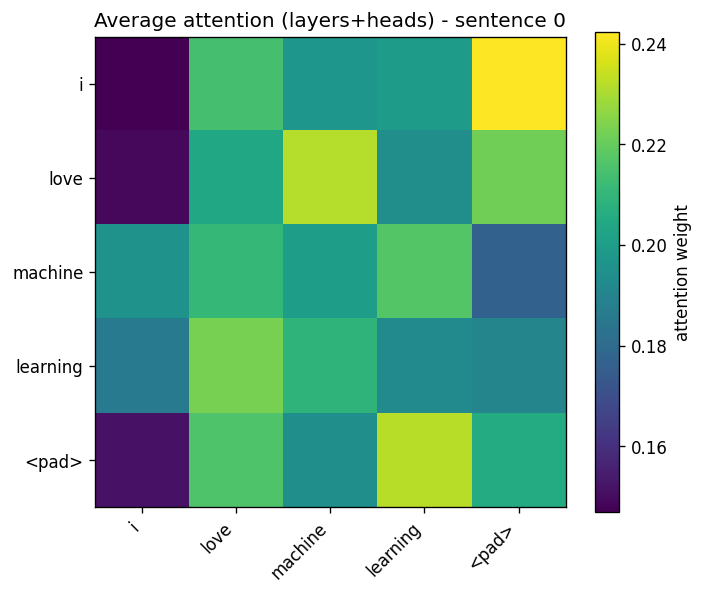

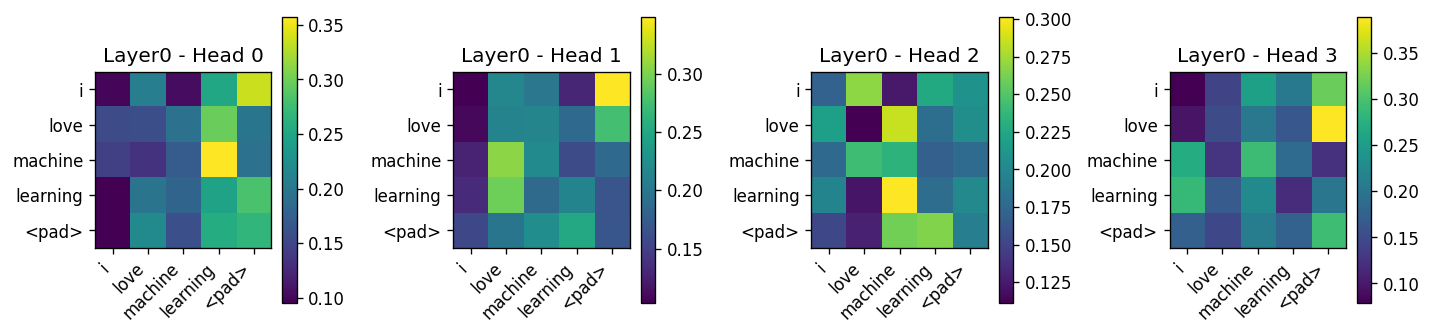


Done. You can inspect `final_embeddings` (numpy array) and saved attention plots above.


In [4]:
# Q2 — Mini Transformer Encoder for Sentences

import math, random, numpy as np, torch, torch.nn as nn
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 120
random.seed(42); np.random.seed(42); torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -------------------- Q2.1: Small dataset (10 short sentences) --------------------
sentences = [
    "I love machine learning",
    "transformers are powerful",
    "pavani wrote this code",
    "self attention is useful",
    "this is a short sentence",
    "we test a mini encoder",
    "heads capture different relations",
    "positional encodings add order",
    "feed forward expands features",
    "final embeddings are contextual"
]

# -------------------- Q2.2: Tokenize and build vocab (simple whitespace tokenizer) ----
tokens = [s.lower().split() for s in sentences]
vocab = {"<pad>":0, "<unk>":1}
for tlist in tokens:
    for w in tlist:
        if w not in vocab:
            vocab[w] = len(vocab)
inv_vocab = {i:w for w,i in vocab.items()}
print("Vocab size:", len(vocab))

# Convert sentences to indices and pad to max_len
max_len = max(len(t) for t in tokens)
indexed = []
for tlist in tokens:
    ids = [vocab.get(w, vocab["<unk>"]) for w in tlist]
    ids += [vocab["<pad>"]] * (max_len - len(ids))
    indexed.append(ids)
batch = torch.tensor(indexed, dtype=torch.long, device=device)  # (batch, seq)
print("\nInput tokens (padded):")
for i, tlist in enumerate(tokens):
    print(f"{i:2d}: ", tlist + ["<pad>"]*(max_len - len(tlist)))

# -------------------- Q2.3: Embedding + Sinusoidal Positional Encoding --------------------
d_model = 64   # embedding dimension
emb = nn.Embedding(len(vocab), d_model).to(device)
def sinusoidal_pos_encoding(seq_len, d_model):
    pe = torch.zeros(seq_len, d_model)
    position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe  # (seq_len, d_model)

pos_enc = sinusoidal_pos_encoding(max_len, d_model).to(device)  # (seq, d_model)

# -------------------- Q2.4: Scaled Dot-Product Attention (single-head) --------------------
def scaled_dot_product_attention(Q, K, V, mask=None):
    # Q,K,V: (batch, head, seq, dk)
    dk = Q.size(-1)
    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(dk)  # (batch, head, seq, seq)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    attn = torch.softmax(scores, dim=-1)
    out = torch.matmul(attn, V)  # (batch, head, seq, dk)
    return out, attn

# -------------------- Q2.4: Multi-Head Attention module --------------------
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        self.num_heads = num_heads
        self.dk = d_model // num_heads
        self.wq = nn.Linear(d_model, d_model)
        self.wk = nn.Linear(d_model, d_model)
        self.wv = nn.Linear(d_model, d_model)
        self.out = nn.Linear(d_model, d_model)
    def forward(self, x, mask=None):
        # x: (batch, seq, d_model)
        B, S, _ = x.size()
        Q = self.wq(x).view(B, S, self.num_heads, self.dk).transpose(1,2)  # (B, heads, S, dk)
        K = self.wk(x).view(B, S, self.num_heads, self.dk).transpose(1,2)
        V = self.wv(x).view(B, S, self.num_heads, self.dk).transpose(1,2)
        out, attn = scaled_dot_product_attention(Q, K, V, mask)  # out: (B, heads, S, dk)
        out = out.transpose(1,2).contiguous().view(B, S, self.num_heads * self.dk)  # (B,S,d_model)
        return self.out(out), attn  # attn: (B, heads, S, S)

# -------------------- Q2.4: Position-wise Feed-Forward --------------------
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
    def forward(self, x):
        return self.net(x)

# -------------------- Q2.4: Add & Norm wrapper --------------------
class AddNorm(nn.Module):
    def __init__(self, d_model, eps=1e-6):
        super().__init__()
        self.norm = nn.LayerNorm(d_model, eps=eps)
    def forward(self, x, sublayer_out):
        return self.norm(x + sublayer_out)

# -------------------- Q2.4: Encoder Layer (MHA -> Add&Norm -> FF -> Add&Norm) --------------------
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff=256):
        super().__init__()
        self.mha = MultiHeadSelfAttention(d_model, num_heads)
        self.addnorm1 = AddNorm(d_model)
        self.ff = FeedForward(d_model, d_ff)
        self.addnorm2 = AddNorm(d_model)
    def forward(self, x, mask=None):
        mha_out, attn = self.mha(x, mask)         # (B,S,d_model), (B,heads,S,S)
        x = self.addnorm1(x, mha_out)
        ff_out = self.ff(x)
        x = self.addnorm2(x, ff_out)
        return x, attn

# -------------------- Q2.5: Build tiny encoder (stack of 2 layers) --------------------
num_heads = 4
encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff=128) for _ in range(2)]).to(device)

# -------------------- Q2.6: Forward pass through encoder --------------------
# Prepare input embeddings + pos encoding
x = emb(batch) + pos_enc.unsqueeze(0)  # (B, S, d_model)
mask = (batch != vocab["<pad>"]).unsqueeze(1).unsqueeze(2)  # (B,1,1,S) not used for self-attn explicitly here

attn_records = []  # collect attention weights per layer
h = x
for layer in encoder_layers:
    h, attn = layer(h, mask=None)  # mask not required for these sentences (no causal)
    attn_records.append(attn.detach().cpu().numpy())  # (B,heads,S,S)

# -------------------- Q2.7: Show input tokens --------------------
print("\nInput (first batch row) tokens:")
print([inv_vocab[idx.item()] for idx in batch[0]])

# -------------------- Q2.8: Final contextual embeddings --------------------
# h : (B,S,d_model)
final_embeddings = h.detach().cpu().numpy()
print("\nFinal contextual embeddings (shape):", final_embeddings.shape)
print("Example token embeddings for sentence 0 (token, embedding[:6]):")
for i, tok_idx in enumerate(batch[0]):
    tok = inv_vocab[tok_idx.item()]
    emb_slice = final_embeddings[0, i, :6]
    print(f"{i:2d}: {tok:12s} {np.array2string(emb_slice, precision=4, separator=',')}")

# -------------------- Q2.9: Attention heatmaps --------------------
# We will plot attention averaged over layers and heads, and also show per-head for layer 0
B, H, S, _ = attn_records[0].shape
# average attention across layers and heads for batch index 0
avg_attn = np.mean([np.mean(layer_attn[0], axis=0) for layer_attn in attn_records], axis=0)  # (S,S)

tokens0 = [inv_vocab[idx.item()] for idx in batch[0]]

plt.figure(figsize=(6,5))
plt.imshow(avg_attn, cmap='viridis')
plt.colorbar(label='attention weight')
plt.xticks(range(S), tokens0, rotation=45, ha='right')
plt.yticks(range(S), tokens0)
plt.title("Average attention (layers+heads) - sentence 0")
plt.tight_layout()
plt.show()

# Per-head heatmaps for first encoder layer, batch 0
layer0_attn = attn_records[0][0]  # (heads, S, S)
fig, axs = plt.subplots(1, min(num_heads,4), figsize=(3*num_heads,3))
for h_i in range(min(num_heads,4)):
    ax = axs[h_i] if num_heads>1 else axs
    im = ax.imshow(layer0_attn[h_i], cmap='viridis')
    ax.set_xticks(range(S)); ax.set_yticks(range(S))
    ax.set_xticklabels(tokens0, rotation=45, ha='right')
    ax.set_yticklabels(tokens0)
    ax.set_title(f"Layer0 - Head {h_i}")
    fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

# -------------------- Q2.10: Return / Save --------------------
# Print a short confirmation that outputs are ready
print("\nDone. You can inspect `final_embeddings` (numpy array) and saved attention plots above.")


In [6]:
# Q3 — Scaled Dot-Product Attention 

import math
import torch
import torch.nn.functional as F
import numpy as np

torch.manual_seed(42)
np.set_printoptions(precision=4, suppress=True)

def scaled_dot_product_attention(Q, K, V, return_scores=False):
    """
    Q: (B, S_q, d_k)
    K: (B, S_k, d_k)
    V: (B, S_k, d_v)
    Returns:
      out: (B, S_q, d_v)
      attn: (B, S_q, S_k)
      raw_scores: (B, S_q, S_k)
      scaled_scores: (B, S_q, S_k)
    """
    d_k = Q.size(-1)
    # raw dot products
    raw_scores = torch.bmm(Q, K.transpose(1, 2))           # (B, S_q, S_k)
    # scaled scores
    scaled_scores = raw_scores / math.sqrt(d_k)           # (B, S_q, S_k)
    # attention weights (softmax over keys)
    attn = F.softmax(scaled_scores, dim=-1)               # (B, S_q, S_k)
    # attention output
    out = torch.bmm(attn, V)                              # (B, S_q, d_v)
    if return_scores:
        return out, attn, raw_scores, scaled_scores
    return out, attn

# -----------------------------
# Create random test inputs
# -----------------------------
B = 1
S_q = 3
S_k = 4
d_k = 64
d_v = 64

# Use relatively large random scale to illustrate instability if present
Q = torch.randn(B, S_q, d_k) * 5.0
K = torch.randn(B, S_k, d_k) * 5.0
V = torch.randn(B, S_k, d_v) * 1.0

out, attn, raw_scores, scaled_scores = scaled_dot_product_attention(Q, K, V, return_scores=True)

# -----------------------------
# Print shapes
# -----------------------------
print("Shapes:")
print(" Q:", tuple(Q.shape))
print(" K:", tuple(K.shape))
print(" V:", tuple(V.shape))
print(" raw_scores:", tuple(raw_scores.shape))
print(" scaled_scores:", tuple(scaled_scores.shape))
print(" attn (weights):", tuple(attn.shape))
print(" out:", tuple(out.shape))
print()

# -----------------------------
# Print attention weight matrix (batch 0)
# -----------------------------
print("Attention weight matrix (batch 0) -- shape (S_q x S_k):")
print(attn[0].cpu().numpy())
print()

# -----------------------------
# Print output vectors (batch 0) - show first 6 dims for brevity
# -----------------------------
print("Output vectors (batch 0), showing first 6 dims of each query position:")
out_np = out[0].cpu().numpy()
for i in range(out_np.shape[0]):
    print(f" q_pos {i}: {out_np[i,:6]}")
print()

# -----------------------------
# Softmax stability check (before and after scaling)
# -----------------------------
raw_np = raw_scores[0].cpu().numpy()       # (S_q, S_k)
scaled_np = scaled_scores[0].cpu().numpy() # (S_q, S_k)

def stable_softmax_np(x):
    x_shift = x - np.max(x, axis=-1, keepdims=True)
    e = np.exp(x_shift)
    return e / e.sum(axis=-1, keepdims=True)

# Direct (unsafe) softmax on raw (may overflow -> inf/nan)
with np.errstate(over='ignore', invalid='ignore'):
    direct_raw = np.exp(raw_np) / np.exp(raw_np).sum(axis=-1, keepdims=True)

# Stabilized softmax on raw (subtract max)
stabilized_raw = stable_softmax_np(raw_np)

# Softmax on scaled scores
soft_scaled = stable_softmax_np(scaled_np)  # stable implementation used here too

print("Softmax stability check (batch 0):")
print(" raw_scores max per query:", np.round(raw_np.max(axis=-1),4))
print(" scaled_scores max per query:", np.round(scaled_np.max(axis=-1),4))
print()

print("Direct softmax on raw_scores (may contain inf/nan):")
print(direct_raw)
print()

print("Stabilized softmax on raw_scores (subtract-max):")
print(stabilized_raw)
print()

print("Softmax on SCALED scores (what Transformer uses):")
print(soft_scaled)
print()

# Compare stabilized raw softmax vs scaled softmax
diff = np.abs(stabilized_raw - soft_scaled)
print("Mean absolute difference between stabilized-softmax(raw) and softmax(scaled):", np.round(diff.mean(),8))
print("Max absolute difference:", np.round(diff.max(),8))
print()

# -----------------------------
# Small explanatory print (for report)
# -----------------------------
print("Note: Direct softmax on large raw scores can overflow and produce NaNs.")
print("Scaling by sqrt(d_k) reduces logits magnitude; alternatively, applying a numerically")
print("stable softmax (subtracting the row-wise max before exp) prevents overflow as well.")


Shapes:
 Q: (1, 3, 64)
 K: (1, 4, 64)
 V: (1, 4, 64)
 raw_scores: (1, 3, 4)
 scaled_scores: (1, 3, 4)
 attn (weights): (1, 3, 4)
 out: (1, 3, 64)

Attention weight matrix (batch 0) -- shape (S_q x S_k):
[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]]

Output vectors (batch 0), showing first 6 dims of each query position:
 q_pos 0: [-0.8032 -1.1209  0.1956 -0.7815 -1.7899 -0.2616]
 q_pos 1: [-1.3839  0.4869 -1.002   0.033  -0.4292 -0.9818]
 q_pos 2: [-0.8032 -1.1209  0.1956 -0.7815 -1.7899 -0.2616]

Softmax stability check (batch 0):
 raw_scores max per query: [241.9334 219.8448 292.3046]
 scaled_scores max per query: [30.2417 27.4806 36.5381]

Direct softmax on raw_scores (may contain inf/nan):
[[ 0.  0. nan  0.]
 [nan  0.  0. nan]
 [ 0.  0. nan  0.]]

Stabilized softmax on raw_scores (subtract-max):
[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]]

Softmax on SCALED scores (what Transformer uses):
[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]]

Mean absolute difference between stabilized-so